In [1]:
# Import libraries and set parameters

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller

print("Numpy version", np.__version__)
print("Pandas version", pd.__version__)
print("Seaborn version", sns.__version__)

Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [2]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum() / len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100

    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me, rmse, mape, wape))

In [3]:
import pandas as pd

pm25_patient_asthma = pd.read_csv(
    "pm25_patient.csv", header=0, index_col=0, parse_dates=True
)

In [4]:
pm25_patient_asthma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82871 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   province    82871 non-null  object 
 1   no_patient  82871 non-null  int64  
 2   pm25        72349 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [5]:
pm25_patient_asthma

,province,no_patient,pm25
date,,,
2020-01-01,กรุงเทพมหานคร,18,20.666667
2020-01-01,กาญจนบุรี,12,38.000000
2020-01-01,ขอนแก่น,36,20.000000
2020-01-01,ฉะเชิงเทรา,13,15.000000
2020-01-01,ชลบุรี,21,23.000000
...,...,...,...
2023-12-31,อ่างทอง,1,45.600000
2023-12-31,เชียงใหม่,1,20.650000
2023-12-31,เพชรบูรณ์,1,23.000000


In [6]:
# เติมค่าที่หายไปในคอลัมน์ pm25 ด้วย interpolation
pm25_patient_asthma["pm25"] = pm25_patient_asthma["pm25"].interpolate(method="linear")

In [7]:
pm25_patient_asthma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82871 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   province    82871 non-null  object 
 1   no_patient  82871 non-null  int64  
 2   pm25        82871 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [8]:
pm25_patient_asthma.sort_index(ascending=True)

,province,no_patient,pm25
date,,,
2020-01-01,กรุงเทพมหานคร,18,20.666667
2020-01-01,กาญจนบุรี,12,38.000000
2020-01-01,ขอนแก่น,36,20.000000
2020-01-01,ฉะเชิงเทรา,13,15.000000
2020-01-01,ชลบุรี,21,23.000000
...,...,...,...
2023-12-31,อ่างทอง,1,45.600000
2023-12-31,เชียงใหม่,1,20.650000
2023-12-31,เพชรบูรณ์,1,23.000000


In [9]:
# สร้าง dictionary เพื่อเก็บข้อมูลแยกตามจังหวัด
province_data = {}

# รายการจังหวัดทั้งหมดใน DataFrame
provinces = pm25_patient_asthma["province"].unique()

# แยกข้อมูลตามจังหวัด
for province in provinces:
    province_data[province] = pm25_patient_asthma[
        pm25_patient_asthma["province"] == province
    ]

MHS_data = province_data["แม่ฮ่องสอน"]
print(MHS_data.head())

              province  no_patient  pm25
date                                    
2020-01-01  แม่ฮ่องสอน           5  24.0
2020-01-02  แม่ฮ่องสอน          14  18.0
2020-01-03  แม่ฮ่องสอน           4  16.0
2020-01-04  แม่ฮ่องสอน           2  25.0
2020-01-05  แม่ฮ่องสอน           6  26.0


In [10]:
pmmhs_Y = pd.Series(MHS_data["pm25"])
print(pmmhs_Y.head())

date
2020-01-01    24.0
2020-01-02    18.0
2020-01-03    16.0
2020-01-04    25.0
2020-01-05    26.0
Name: pm25, dtype: float64


In [11]:
pmmhs_X = pd.Series(MHS_data["no_patient"])
print(pmmhs_X.head())

date
2020-01-01     5
2020-01-02    14
2020-01-03     4
2020-01-04     2
2020-01-05     6
Name: no_patient, dtype: int64


In [ ]:
MHS_data.plot(figsize=(10, 4))

In [12]:
# ทดสอบว่า stationary หรือไม่ หาก p-value น้อยกว่า 0.05 > stationary
print("Results of Augmented Dickey-Fuller Test:")
dftest = adfuller(pmmhs_Y)
dfoutput = pd.Series(dftest[0:2], index=["Test Statistic", "p-value"])
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic   -3.555675
p-value           0.006667
dtype: float64


In [13]:
print("Results of Augmented Dickey-Fuller Test:")
dftest = adfuller(pmmhs_X)
dfoutput = pd.Series(dftest[0:2], index=["Test Statistic", "p-value"])
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic   -5.744445e+00
p-value           6.167814e-07
dtype: float64


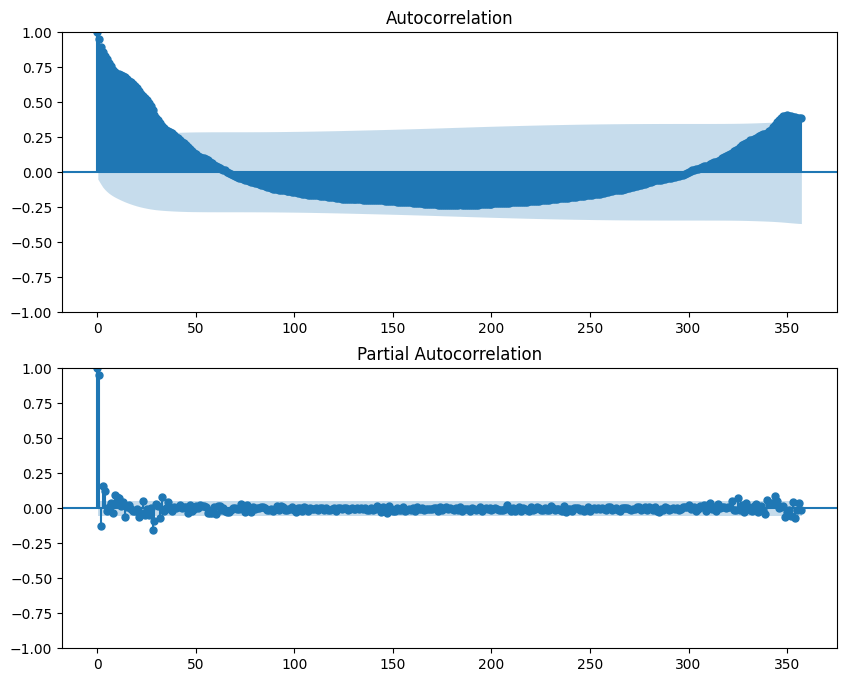

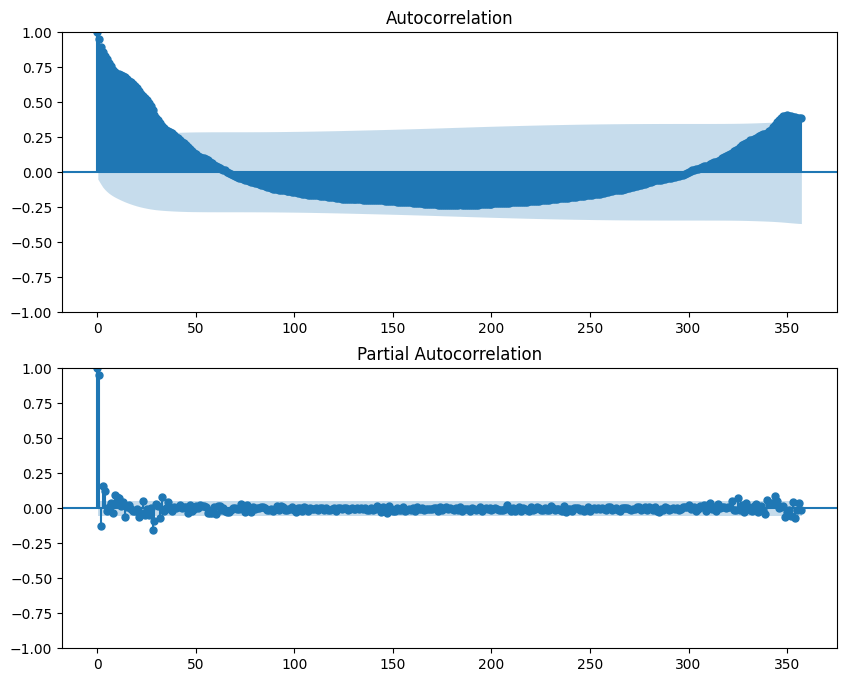

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = max(10, len(pmmhs_Y) / 4)
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plot_acf(pmmhs_Y, lags=max_lag, ax=ax1)
plot_pacf(pmmhs_Y, lags=max_lag, ax=ax2)

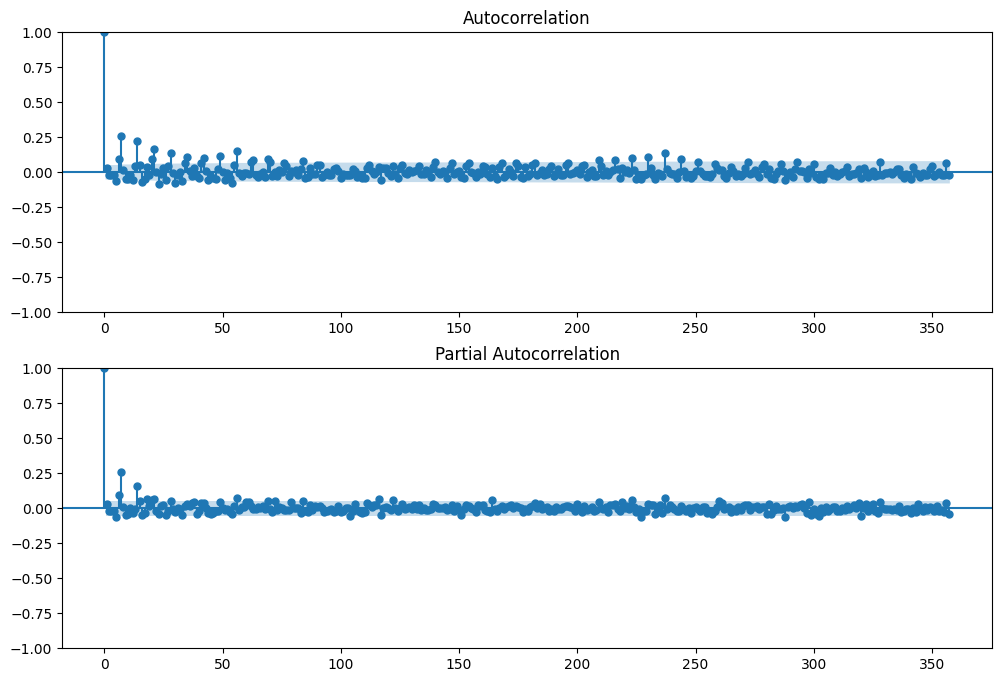

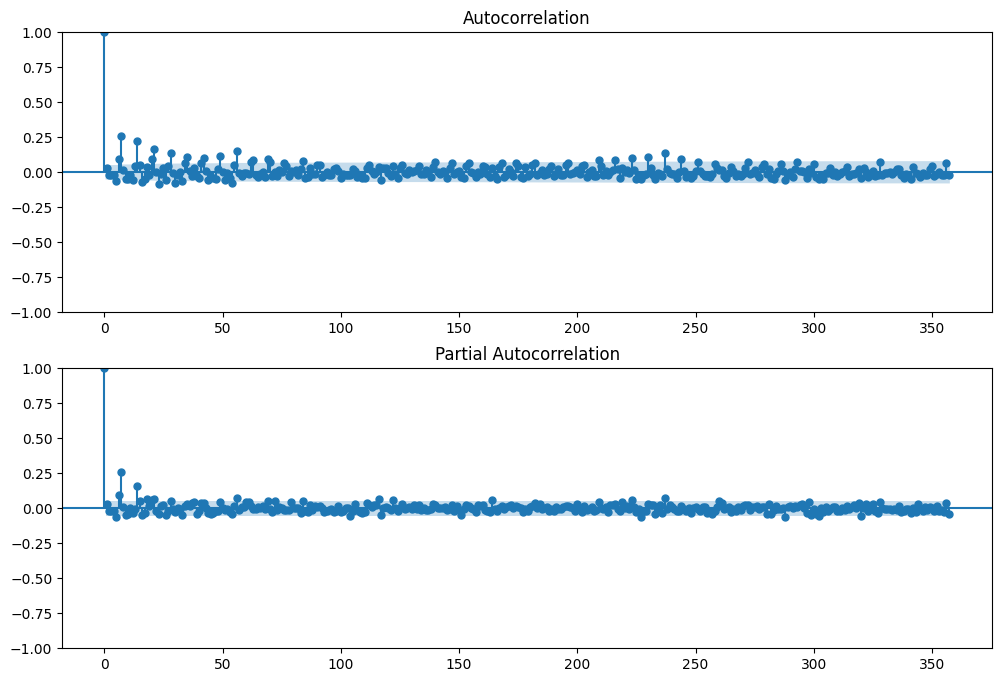

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = max(10, len(pmmhs_X) / 4)
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
plot_acf(pmmhs_X, lags=max_lag, ax=ax1)
plot_pacf(pmmhs_X, lags=max_lag, ax=ax2)

In [16]:
split_ratio = 0.8
train_size = int(len(pmmhs_X) * split_ratio)
Y_train, Y_test = pmmhs_X[:train_size], pmmhs_X[train_size:]

In [17]:
# หาช่วงเวลาที่ตรงกัน
common_index = Y_train.index.intersection(pmmhs_X.index)

# กรองข้อมูลให้ตรงตามช่วงเวลาที่ตรงกัน
Y_train = Y_train.loc[common_index]
pmmhs_X = pmmhs_X.loc[common_index]

In [18]:
import itertools

Y_train = MHS_data["pm25"]
pmmhs_X = MHS_data["no_patient"]

# กำหนดค่า p, d, q และ P, D, Q ที่ต้องการลอง
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(
                Y_train,
                exog=pmmhs_X,
                order=param,
                seasonal_order=param_seasonal,
                trend="c",
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print(f"Best SARIMA{best_pdq}x{best_seasonal_pdq}12 model - AIC:{best_aic}")
print(best_model.summary())

c:\Users\brown\.virtualenvs\testenv-eP_-TuEa\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\brown\.virtualenvs\testenv-eP_-TuEa\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\brown\.virtualenvs\testenv-eP_-TuEa\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\brown\.virtualenvs\testenv-eP_-TuEa\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

Best SARIMA(2, 0, 2)x(0, 1, 1, 12)12 model - AIC:11384.059825448485
                                      SARIMAX Results                                       
Dep. Variable:                                 pm25   No. Observations:                 1431
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -5684.030
Date:                              Wed, 17 Jul 2024   AIC                          11384.060
Time:                                      02:05:48   BIC                          11426.121
Sample:                                           0   HQIC                         11399.773
                                             - 1431                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

pdq = (0, 0, 3)
pmmhs_model = SARIMAX(Y_train, exog=pmmhs_X, order=pdq, trend="c").fit(disp=False)

In [ ]:
print(pmmhs_model.summary())

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(pmmhs_X, alpha=0.5, label="Train data")
plt.plot(pmmhs_model.fittedvalues, "--o", color="green", ms=2, label="Fitted values")
plt.legend(loc="best")
plt.tight_layout()

In [ ]:
pmmhs_model.plot_diagnostics(figsize=(9, 7))
plt.tight_layout()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

x = pmmhs_model.resid
h = min(10, int(len(x) / 5))
lb_result = acorr_ljungbox(x, lags=h)
print(lb_result)

In [ ]:
history = [y for y in Y_train]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 1
for t in range(len(Y_test) - (h - 1)):

    model_fit = SARIMAX(train, order=pdq, trend="c").fit(disp=False)

    output = model_fit.get_forecast(h)
    predictions.append(output.predicted_mean[h - 1])
    lower_ci.append(output.conf_int()[h - 1, 0])
    upper_ci.append(output.conf_int()[h - 1, 1])

    history.append(Y_test.iloc[t])
    train = history[t + 1 :]

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(Y_train, label="Train set", color="red", alpha=0.6)
plt.plot(Y_test, label="Test set", color="blue", alpha=0.6)

predictions = pd.Series(predictions, index=Y_test.index[h - 1 :])
plt.plot(predictions, "go:", label="Predicted", alpha=0.6, ms=4)
plt.fill_between(Y_test.index[h - 1 :], upper_ci, lower_ci, color="#ff0066", alpha=0.25)
plt.legend(loc="best")
plt.tight_layout()

get_forecast_accuracy(Y_test[h - 1 :], predictions)